# Author: Michael Elgin (melgin@uwyo.edu)
# 2023_11_27

# Notebook for Wildcard Project - Examining the effect of image rotation on the performance of convolutional neural nets.

So far the wine quality dataset has been used. In this last repo, image data will be used instead. The CIFAR-10 dataset will be used to train a few different convolutional neural net models, and then their baseline performance on the given CIFAR-10 data will be compared to the same model architectures which have been trained on an augmented training set 4 times the size, which includes having each image rotated 90, 180, and 270 degrees.

The exact model architectures and hyperparameter settings are not of concern here, only isolating out the effect of image rotation is. But of course this means that the architectures and hyperparmeters, whatever they are, shall remain consistent between training of each model.

This will be a simple train-test split. *All* models will be evalated on the exact same test set. Both the normal training and rotated training sets will be the same for each model that uses each respective set.

## Part 1 - Loading the CIFAR-10 data

In [2]:
#The most vanilla way to get the CIFAR-10 data is by the site https://www.cs.toronto.edu/~kriz/cifar.html
#However, tensorflow allows a direct load of it and the rest of the notebook will require tensorflow anyway.
#Here is a load snippet from https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [3]:
#Create label decoder
label_decoder = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

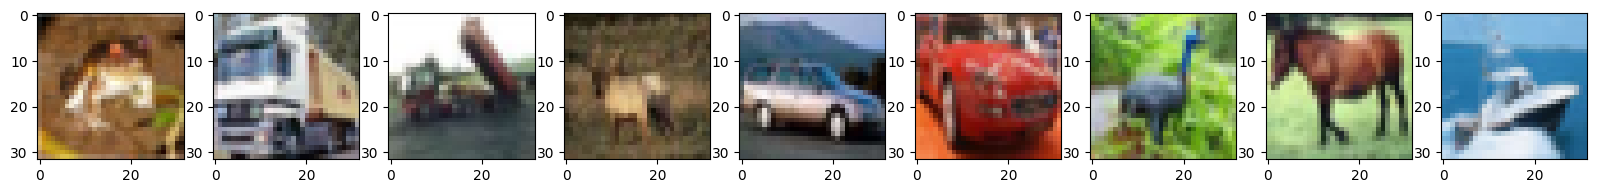

In [4]:
#Examine the images to confirm they are as expected
import matplotlib.pyplot as plt

#Some control parameters
images = 9
size = 20

fig, axes = plt.subplots(1, images, figsize=(size,size))
for idx in range(images):
    axes[idx].imshow(x_train[idx])

In [5]:
#Next create the arrays of rotated images
from PIL import Image

x_train_90 = [Image.fromarray(image).rotate(90) for image in x_train]
x_train_180 = [Image.fromarray(image).rotate(180) for image in x_train]
x_train_270 = [Image.fromarray(image).rotate(270) for image in x_train]

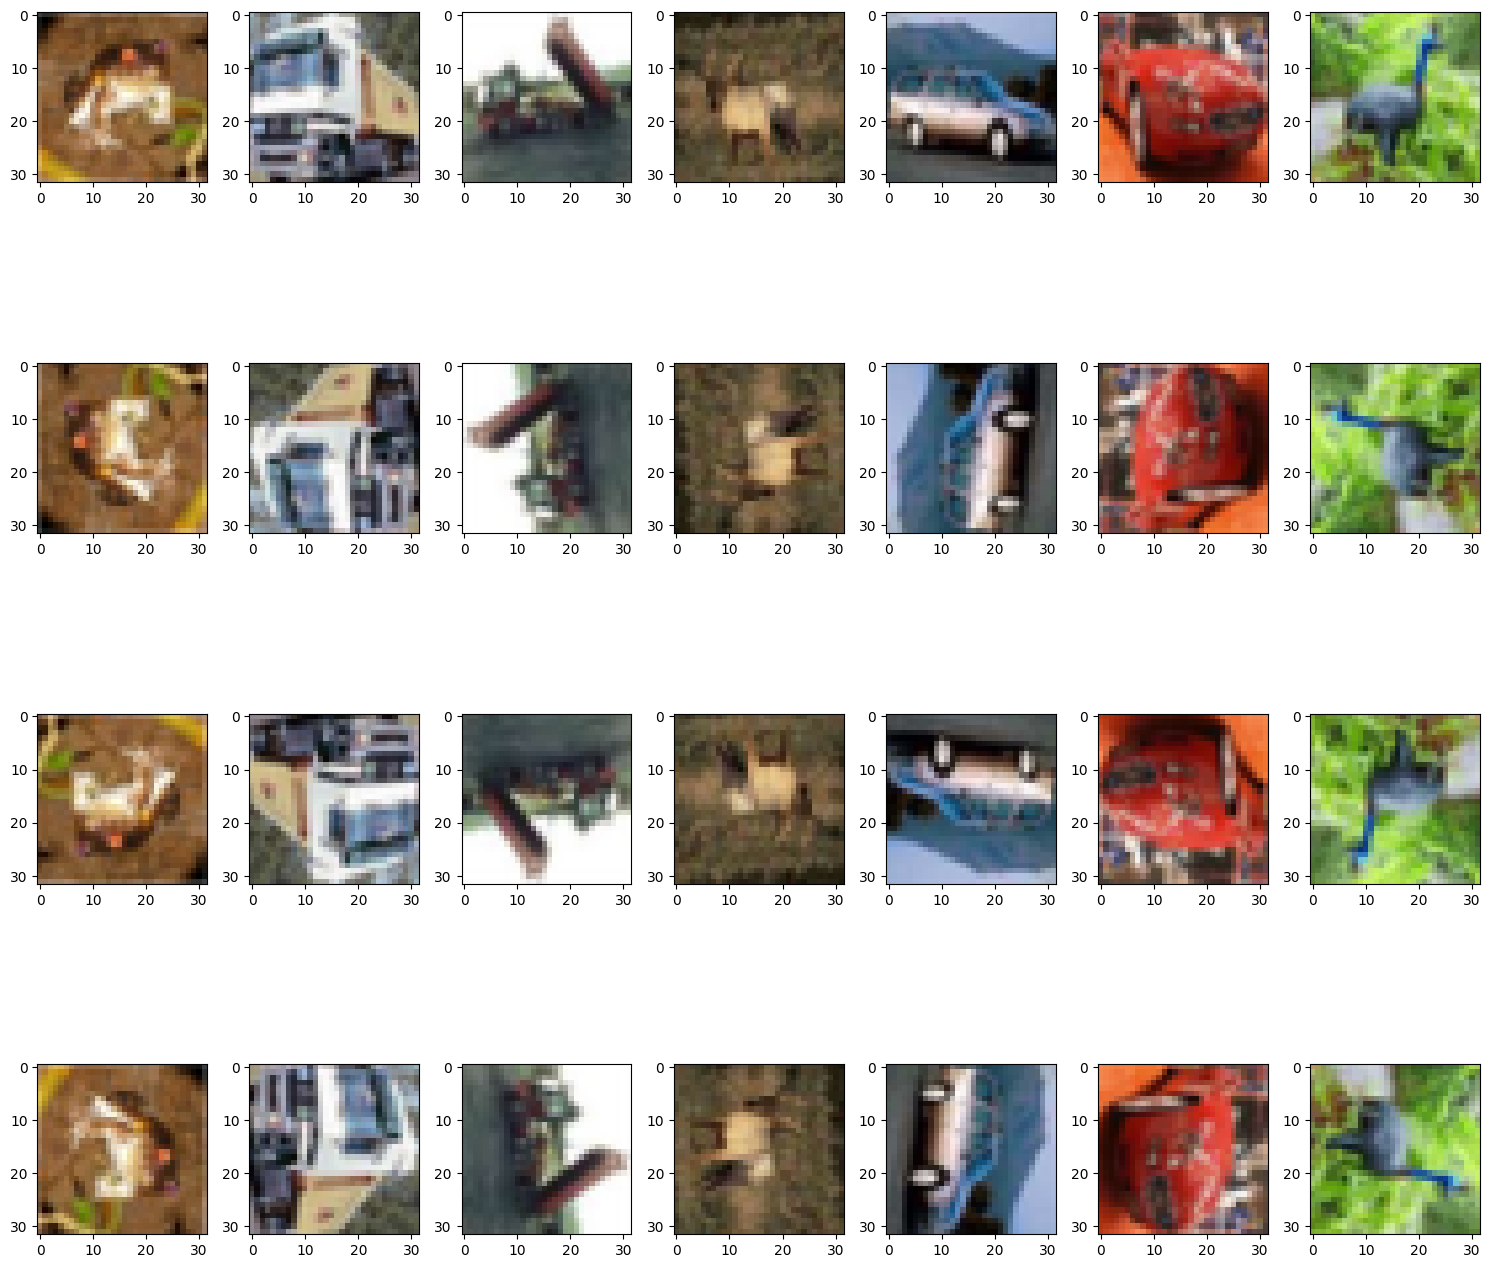

In [6]:
#And now the display
images = 7
size = 15

fig, axes = plt.subplots(4, images, figsize=(size,size))
for idx in range(images):
    axes[0][idx].imshow(x_train[idx])
    axes[1][idx].imshow(x_train_90[idx])
    axes[2][idx].imshow(x_train_180[idx])
    axes[3][idx].imshow(x_train_270[idx])
fig.tight_layout()

In [7]:
#Now to concatenate all the rotations into one augmented dataset
import numpy as np

x_train_rotation = np.concatenate([x_train, x_train_90, x_train_180, x_train_270], axis=0)
y_train_rotation = np.concatenate([y_train, y_train, y_train, y_train], axis=0)

assert x_train_rotation.shape == (200000, 32, 32, 3)
assert y_train_rotation.shape == (200000, 1)
assert x_train.shape == (50000, 32, 32, 3)
assert y_train.shape == (50000, 1)


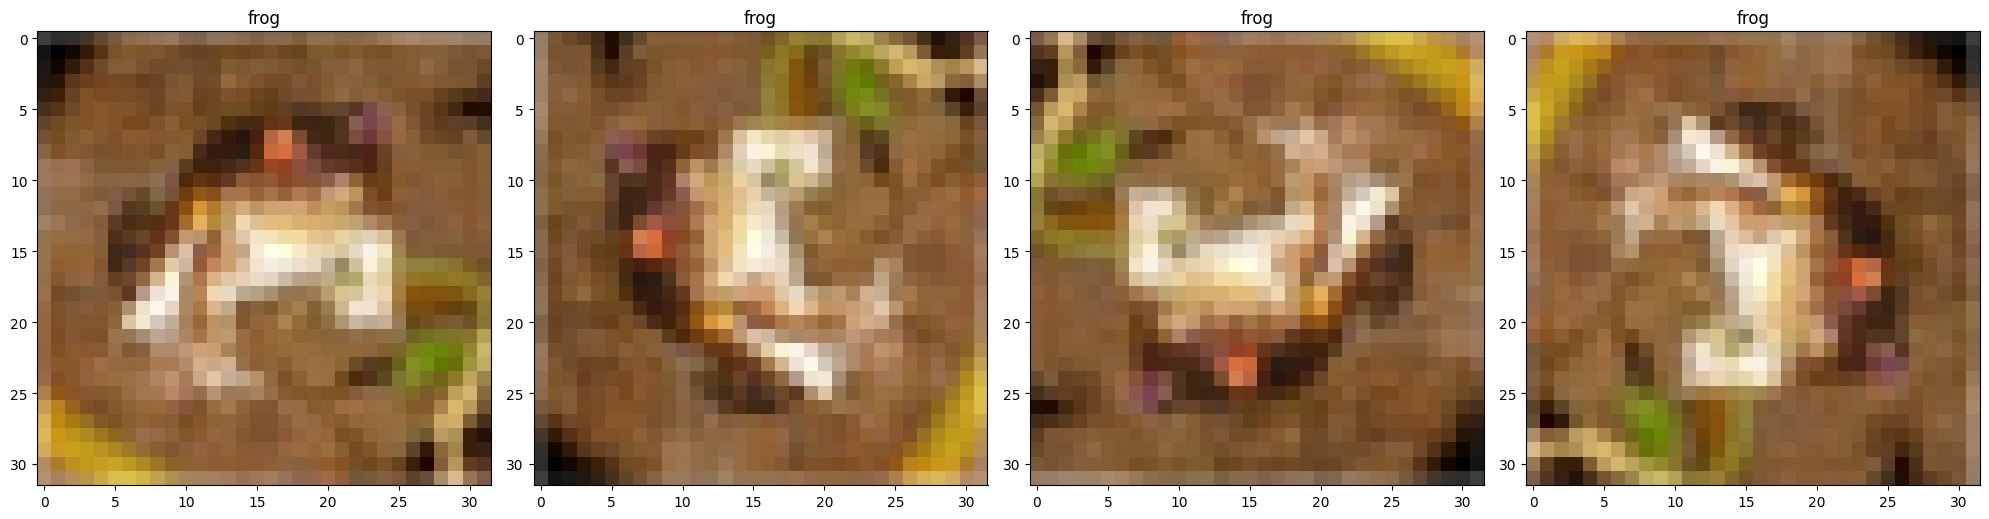

In [8]:
#If the new datasets are working properly, we should see the same image only rotated at each offset of 50,000
images = 4
size = 20

fig, axes = plt.subplots(1, images, figsize=(size,size))
for idx in range(images):
    col = idx * x_train.shape[0]
    axes[idx].imshow(x_train_rotation[col])
    axes[idx].set_title(label_decoder[y_train_rotation[col][0]]) #They should all have the same label number up top
fig.tight_layout()

In [9]:
#Target must be one-hot encoded to match shape of output layer in the models later
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)#is guaranteed to always be 10
y_train_rotation = to_categorical(y_train_rotation, 10)

print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Part 2 - Creating some CNN models

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [11]:
#Model is based on model 2 from https://github.com/Mikey-E/U-of-Wyo-ML-5555-01-22772-Spring-2023-Research-Project/blob/main/src/classifier.py,
#from a different kind of data augmentation project.
def make_model1(input_shape=x_train.shape[1:]):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model

In [12]:
def make_model2(input_shape=x_train.shape[1:]):
    """Similar to model 1, containing an extra convolution layer"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model


In [13]:
def make_model3(input_shape=x_train.shape[1:]):
    """Similar to model 1, using different kernel size for the convolution"""
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model


## Part 3 - Training

In [17]:
import pickle #To save things so training need not be redone

In [14]:
#Create all models to be trained and tested
model1 = make_model1()
model1_rotation = make_model1()
model2 = make_model2()
model2_rotation = make_model2()
model3 = make_model3()
model3_rotation = make_model3()

In [15]:
#Create control parameters for all model fits
batch_size = 32
epochs = 10
validation_split = 0.2
shuffle=True

In [15]:
#Train the models, save them and their training histories for examination later so this long cell need not be run each time
for name, model in zip( ["model1", "model2", "model3", "model1_rotation", "model2_rotation", "model3_rotation"],
                        [model1, model2, model3, model1_rotation, model2_rotation, model3_rotation]):
        model_history = model.fit(
                (x_train if "rotation" not in name else x_train_rotation),
                (y_train if "rotation" not in name else y_train_rotation),
                batch_size=batch_size,
                epochs=epochs,
                validation_split=validation_split,
                shuffle=shuffle
        )
        with open("./histories/" + name + "_history", "wb") as f:
                pickle.dump(model_history, f)
        model.save("./models/" + name + ".h5")

Epoch 1/10
1250/1250 [==============================] - 68s 54ms/step - loss: 3.6185 - accuracy: 0.2912 - val_loss: 1.6566 - val_accuracy: 0.4161
Epoch 2/10
1250/1250 [==============================] - 67s 54ms/step - loss: 1.6917 - accuracy: 0.3961 - val_loss: 1.5259 - val_accuracy: 0.4578
Epoch 3/10
1250/1250 [==============================] - 67s 54ms/step - loss: 1.5910 - accuracy: 0.4339 - val_loss: 1.4832 - val_accuracy: 0.4888
Epoch 4/10
1250/1250 [==============================] - 66s 53ms/step - loss: 1.5415 - accuracy: 0.4576 - val_loss: 1.4638 - val_accuracy: 0.4822
Epoch 5/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.4842 - accuracy: 0.4801 - val_loss: 1.4561 - val_accuracy: 0.4971
Epoch 6/10
1250/1250 [==============================] - 67s 53ms/step - loss: 1.4591 - accuracy: 0.4948 - val_loss: 1.3897 - val_accuracy: 0.5239
Epoch 7/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.4215 - accuracy: 0.5090 - val_loss: 1.4513 -

## Part 4 - Evaluation

In [16]:
#Performance (accuracy) at each epoch
with open("histories/model1_history", "rb") as f:
    model1_history = pickle.load(f)
with open("histories/model2_history", "rb") as f:
    model2_history = pickle.load(f)
with open("histories/model3_history", "rb") as f:
    model3_history = pickle.load(f)
with open("histories/model1_rotation_history", "rb") as f:
    model1_rotation_history = pickle.load(f)
with open("histories/model2_rotation_history", "rb") as f:
    model2_rotation_history = pickle.load(f)
with open("histories/model3_rotation_history", "rb") as f:
    model3_rotation_history = pickle.load(f)

print(model1_history.history)

NameError: name 'pickle' is not defined

In [17]:
#The results on the test set
from keras.models import load_model

model = load_model("models/model1.h5")


#@@@ just print 'em out next to each model name
